In [ ]:
import scipy.io
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import os
import math, time
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1

    return patchesData, patchesLabels.astype("int")

In [ ]:
data = envi.open('./drive/MyDrive/HSI-datasets/IP_DataSet/indianpines_ds_raw.hdr', \
                './drive/MyDrive/HSI-datasets/IP_DataSet/indianpines_ds_raw.raw')

In [ ]:
disjoint_pixels = envi.open('./drive/MyDrive/HSI-datasets/IP_TrainSet/indianpines_ts_raw_classes.hdr', \
                './drive/MyDrive/HSI-datasets/IP_TrainSet/indianpines_ts_raw_classes.raw')

In [ ]:
disjoint_pixels = disjoint_pixels.read_bands([0])
disjoint_pixels = disjoint_pixels.reshape(disjoint_pixels.shape[0], disjoint_pixels.shape[1])

In [ ]:
y_train = copy.deepcopy(disjoint_pixels)
for i, val in enumerate([0,2,3,5,6,8,10,11,12,14,1,4,7,9,13,15,16]): y_train[disjoint_pixels==i] = val

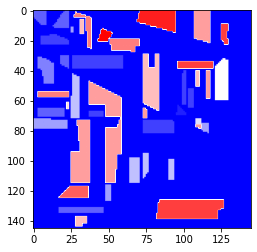

In [ ]:
# Plot the grid
plt.imshow(y_train, cmap='bwr')
plt.show()

In [ ]:
labels = scipy.io.loadmat('./drive/MyDrive/HSI-datasets/indian_pines_gt.mat')
labels = labels['indian_pines_gt']

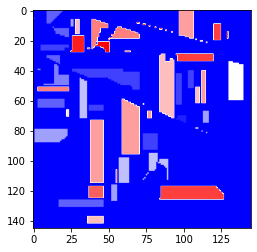

In [ ]:
# Plot the grid
plt.imshow(y_test, cmap='bwr')
plt.show()

In [ ]:
dataset = ['India', 'Pavia'][1]
random_split = True

In [ ]:
if dataset == 'India':
    raw_data = scipy.io.loadmat('./drive/MyDrive/HSI-datasets/indian_pines_corrected.mat')
    disjoint_data = scipy.io.loadmat(os.getcwd() + '/drive/MyDrive/HSI-datasets/indianpines_disjoint_dset.mat')
    all_labels = scipy.io.loadmat(os.getcwd() + '/drive/MyDrive/HSI-datasets/indian_pines_gt.mat')

    X_all = raw_data['indian_pines_corrected']
    y_disjoint = disjoint_data['indianpines_disjoint_dset']
    y_all = all_labels['indian_pines_gt']

    test_ratio = 0.45
else:
    raw_data = scipy.io.loadmat('./drive/MyDrive/HSI-datasets/paviaU.mat')
    disjoint_data = scipy.io.loadmat(os.getcwd() + '/drive/MyDrive/HSI-datasets/TRpavia_fixed.mat')
    all_labels = scipy.io.loadmat(os.getcwd() + '/drive/MyDrive/HSI-datasets/paviaU_gt.mat')

    X_all = raw_data['paviaU']
    y_disjoint = disjoint_data['TRpavia_fixed']
    y_all = all_labels['paviaU_gt']

    test_ratio = 0.93

In [ ]:
import scipy.io
import numpy as np
import copy
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# -*- coding: utf-8 -*-
# Torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.nn import init
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchsummary import summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
num_channels = X_all.shape[-1]
W = X_all.shape[0]
H = X_all.shape[1]
num_components = 40
window = 19
num_classes = len(np.unique(y_all)) - 1 # Ignore label=0 (undefined class)

In [ ]:
X_all = X_all.reshape(W*H, num_channels)
y_disjoint = y_disjoint.reshape(-1, 1).flatten()

X_all = X_all.astype(np.float32)

In [ ]:
pca = PCA(n_components=num_components)
X_all = pca.fit_transform(X_all)

X_all = X_all.reshape(W, H, num_components)

In [ ]:
X, y = createImageCubes(X_all, y_all, windowSize=window, removeZeroLabels = False)

In [ ]:
np.save('data.npy', X)
np.save('labels.npy', y)

In [ ]:
del X_all, y_all, raw_data, X, y

In [ ]:
X = np.load('data.npy', mmap_mode='c')
y = np.load('labels.npy', mmap_mode='c')

In [ ]:
X = np.transpose(X, (0, 3, 1, 2))

In [ ]:
X.shape

(207400, 40, 19, 19)

In [ ]:
if random_split:
    nonzero_idx = np.where(y != 0)
    X = X[nonzero_idx]
    y = y[nonzero_idx]
    y = y - 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)
else:
    train_idx = np.where((y_disjoint != 0) & (y != 0))
    X_train = X[train_idx]
    y_train = y[train_idx]

    test_idx = np.where((y_disjoint == 0) & (y != 0))
    X_test = X[test_idx]
    y_test = y[test_idx]

    y_train -= 1
    y_test -= 1

    print('Disjoint')

In [ ]:
X_train = X_train.reshape(X_train.shape[0], num_components*window*window)
X_test = X_test.reshape(X_test.shape[0], num_components*window*window)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0], num_components, window, window)
X_test = X_test.reshape(X_test.shape[0], num_components, window, window)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
X_test.shape

(39782, 40, 19, 19)

In [ ]:
tensor_x = torch.Tensor(X_train) # transform to torch tensor
tensor_y = torch.Tensor(y_train)
tensor_y = tensor_y.type(torch.LongTensor)

train_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size=100) # create your dataloader

In [ ]:
tensor_x = torch.Tensor(X_val) # transform to torch tensor
tensor_y = torch.Tensor(y_val)
tensor_y = tensor_y.type(torch.LongTensor)

val_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
val_dataloader = DataLoader(val_dataset, batch_size=100) # create your dataloader

In [ ]:
tensor_x = torch.Tensor(X_test) # transform to torch tensor
tensor_y = torch.Tensor(y_test)
tensor_y = tensor_y.type(torch.LongTensor)

test_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size=100) # create your dataloader

In [ ]:
class cnn2d(nn.Module):
    """
    CNN2d network
    """

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(0.5)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

    def __init__(self, input_channels, n_classes, filters=(50, 100), fc=100, bn=False):
        super(cnn2d, self).__init__()
        self.bn = bn

        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=filters[0], kernel_size=(5, 5))
        if bn:
            self.bn1 = nn.BatchNorm2d(filters[0])
        self.conv2 = nn.Conv2d(in_channels=filters[0], out_channels=filters[1], kernel_size=(5, 5))
        if bn:
            self.bn2 = nn.BatchNorm2d(filters[1])
        self.pool = nn.MaxPool2d((2, 2))

        self.fc1 = nn.Linear(int(25*filters[1]), fc)
        if bn:
            self.bn3 = nn.BatchNorm1d(fc)
        self.fc2 = nn.Linear(fc, n_classes)

        self.apply(self.weight_init)

    def forward(self, x):
        x = self.conv1(x)
        if self.bn:
            x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        if self.bn:
            x = self.bn2(x)
        x = self.pool(F.relu(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        if self.bn:
            x = self.bn3(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
__all__ = ['vgg']

defaultcfg = {
    2: [50, 100, 'M'],
    11 : [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512],
    13 : [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512],
    16 : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512],
    19 : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512],
}

defaultfc = [100, 100]

class vgg(nn.Module):
    def __init__(self, depth=2, init_weights=True, cfg=None, fc=None, n_classes=16, kernel=5, padding=0):
        super(vgg, self).__init__()

        if cfg is None:
            cfg = defaultcfg[depth]
        if fc is not None:
            fc = defaultfc
        self.config = [cfg,fc]
        self.cfg = cfg

        self.feature = self.make_layers(cfg, kernel, padding, batch_norm=False)

        step = kernel - 1 - (2*padding)
        w = 19
        for i in cfg:
            if i != "M":
                w -= step
                last_conv = i
            else:
                w = w // 2
        
        if fc:
            self.classifier = nn.Sequential(
                nn.Linear(int(w*w*last_conv), fc[0]),
                nn.ReLU(True),
                nn.Dropout(0.5),
                nn.Linear(fc[0], fc[1]),
                nn.ReLU(True),
                nn.Dropout(0.5),
                nn.Linear(fc[1], n_classes),
                )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(int(w*w*last_conv), 100),
                nn.Linear(100, n_classes),
                )
        if init_weights:
            self._initialize_weights()

    def make_layers(self, cfg, kernel, padding, batch_norm=False):
        layers = []
        in_channels = num_components
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=kernel, padding=padding, bias=False)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature(x)
        # x = nn.AvgPool2d(2)(x)
        x = x.view(x.size(0), -1)
        y = self.classifier(x)
        return y

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(0.5)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def validate(val_loader, model):
    """validation"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    criterion = nn.CrossEntropyLoss()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for idx, (input, target) in enumerate(val_loader):

            input = input.float()
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))
            top5.update(acc5[0], input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

    return top1.avg, top5.avg, losses.avg

In [ ]:
def train_vanilla(epoch, train_loader, model, criterion, optimizer):
    """vanilla training"""
    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    end = time.time()
    for idx, (input, target) in enumerate(train_loader):
        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        output = model(input)
        loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))
        top5.update(acc5[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()

        # tensorboard logger
        pass

        # print info
        # if idx % print_freq == 0:
        #     print('Epoch: [{0}][{1}/{2}]\t'
        #           'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
        #           'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
        #           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #           'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
        #           'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
        #            epoch, idx, len(train_loader), batch_time=batch_time,
        #            data_time=data_time, loss=losses, top1=top1, top5=top5))
        #     sys.stdout.flush()

    print(' * epoch {}: Losses {losses.avg:.3f} Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'.format(epoch, losses=losses, top1=top1, top5=top5))

    return top1.avg, losses.avg

In [ ]:
def train_big_network(train_loader, val_loader, epochs, cfg, fc):
    best_acc = 0

    # model
    model = cnn2d(num_components, num_classes, filters=cfg, fc=fc)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)

    criterion = nn.CrossEntropyLoss()

    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    # routine
    for epoch in range(1, epochs + 1):

        #adjust_learning_rate(epoch, opt, optimizer)
        print("==> training...")

        time1 = time.time()
        train_acc, train_loss = train_vanilla(epoch, train_loader, model, criterion, optimizer)
        time2 = time.time()

        # print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        test_acc, test_acc_top5, test_loss = validate(val_loader, model)


        # save the best model
        if test_acc > best_acc:
            best_acc = test_acc
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = './best_model.pth'
            print('saving the best model!')
            torch.save(state, save_file)

        # regular saving
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'accuracy': test_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = os.path.join('./', 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

    # This best accuracy is only for printing purpose.
    # The results reported in the paper/README is from the last epoch.
    print('best accuracy:', best_acc)

    # save model
    state = {
        #'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    save_file = './last_model.pth'
    torch.save(state, save_file)

In [ ]:
def train_small_network(model, train_loader, val_loader, epochs):
    best_acc = 0
    best_model = None
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)

    criterion = nn.CrossEntropyLoss()

    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    # routine
    for epoch in range(1, epochs + 1):

        #adjust_learning_rate(epoch, opt, optimizer)
        print("==> training...")

        time1 = time.time()
        train_acc, train_loss = train_vanilla(epoch, train_loader, model, criterion, optimizer)
        time2 = time.time()

        # print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        test_acc, test_acc_top5, test_loss = validate(val_loader, model)


        # save the best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_model = model
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = './best_small_model.pth'
            print('saving the best model!')
            torch.save(state, save_file)

    # This best accuracy is only for printing purpose.
    # The results reported in the paper/README is from the last epoch.
    print('best accuracy:', best_acc)

    # save model
    state = {
        #'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    save_file = './last_small_model.pth'
    torch.save(state, save_file)

    return best_model

In [ ]:
save_freq = 40
print_freq = 200
num_classes = len(np.unique(y_train))

learning_rate = 8e-4

t_cfg = (50, 100) # dimention of teacher conv layers
t_fc = 100 # dimention of teacher linear layers

In [ ]:
train_big_network(train_dataloader, val_dataloader, epochs=200, cfg=t_cfg, fc=t_fc)

==> training...
 * epoch 1: Losses 1.444 Acc@1 47.290 Acc@5 84.744
saving the best model!
==> training...
 * epoch 2: Losses 0.594 Acc@1 79.027 Acc@5 97.142
saving the best model!
==> training...
 * epoch 3: Losses 0.224 Acc@1 91.759 Acc@5 99.926
saving the best model!
==> training...
 * epoch 4: Losses 0.113 Acc@1 96.585 Acc@5 100.000
saving the best model!
==> training...
 * epoch 5: Losses 0.063 Acc@1 98.478 Acc@5 100.000
saving the best model!
==> training...
 * epoch 6: Losses 0.048 Acc@1 98.961 Acc@5 100.000
==> training...
 * epoch 7: Losses 0.039 Acc@1 99.592 Acc@5 100.000
saving the best model!
==> training...
 * epoch 8: Losses 0.034 Acc@1 99.629 Acc@5 100.000
saving the best model!
==> training...
 * epoch 9: Losses 0.042 Acc@1 98.886 Acc@5 100.000
==> training...
 * epoch 10: Losses 0.035 Acc@1 99.480 Acc@5 100.000
==> training...
 * epoch 11: Losses 0.024 Acc@1 99.814 Acc@5 100.000
==> training...
 * epoch 12: Losses 0.024 Acc@1 99.852 Acc@5 100.000
==> training...
 * epoc

In [ ]:
model = cnn2d(num_components, num_classes, filters=t_cfg, fc=t_fc)
model.load_state_dict(torch.load('./best_model.pth')['model'])

<All keys matched successfully>

In [ ]:
model = model.to(device)
t_acc_1, t_acc_5, t_loss = validate(test_dataloader, model)

In [ ]:
print("Big top-1 test accuracy: {:.3f}".format(t_acc_1))
print("Big top-5 test accuracy: {:.3f}".format(t_acc_5))

Big top-1 test accuracy: 99.256
Big top-5 test accuracy: 100.000


In [ ]:
for name, p in model.named_parameters():
    if p.requires_grad:
        print(name, p.numel())

conv1.weight 50000
conv1.bias 50
conv2.weight 125000
conv2.bias 100
fc1.weight 250000
fc1.bias 100
fc2.weight 900
fc2.bias 9


In [ ]:
conv_r = 0.89  # prune ratio of conv layers
linear_r = 0.89 # prune ratio of lienar layers

s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

In [ ]:
train_big_network(train_dataloader, val_dataloader, epochs=200, cfg=s_cfg, fc=s_fc)

==> training...
 * epoch 1: Losses 1.912 Acc@1 41.759 Acc@5 78.248
saving the best model!
==> training...
 * epoch 2: Losses 1.443 Acc@1 43.690 Acc@5 86.229
==> training...
 * epoch 3: Losses 1.311 Acc@1 44.209 Acc@5 86.229
saving the best model!
==> training...
 * epoch 4: Losses 1.232 Acc@1 52.450 Acc@5 86.229
saving the best model!
==> training...
 * epoch 5: Losses 1.092 Acc@1 60.987 Acc@5 89.235
saving the best model!
==> training...
 * epoch 6: Losses 0.882 Acc@1 67.112 Acc@5 93.207
saving the best model!
==> training...
 * epoch 7: Losses 0.762 Acc@1 69.785 Acc@5 95.805
saving the best model!
==> training...
 * epoch 8: Losses 0.703 Acc@1 71.121 Acc@5 96.622
saving the best model!
==> training...
 * epoch 9: Losses 0.660 Acc@1 72.383 Acc@5 97.439
saving the best model!
==> training...
 * epoch 10: Losses 0.621 Acc@1 74.350 Acc@5 97.996
saving the best model!
==> training...
 * epoch 11: Losses 0.582 Acc@1 74.944 Acc@5 98.404
saving the best model!
==> training...
 * epoch 12: Lo

In [ ]:
s_model = cnn2d(num_components, num_classes, filters=s_cfg, fc=s_fc)
s_model.load_state_dict(torch.load('./best_model.pth')['model'])
s_model = s_model.to(device)

In [ ]:
s_acc_1, s_acc_5, s_loss = validate(test_dataloader, s_model)
print("Small top-1 test accuracy: {:.3f}".format(s_acc_1))
print("Small top-5 test accuracy: {:.3f}".format(s_acc_5))

Small top-1 test accuracy: 98.137
Small top-5 test accuracy: 99.997


# **L1-norm magnitude pruning**

In [ ]:
def create_conv_mask(model, cfg):
    cfg_mask = []
    layer_id = 0
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            out_channels = m.weight.data.shape[0]
            if out_channels == cfg[layer_id]:
                cfg_mask.append(torch.ones(out_channels))
                layer_id += 1
                continue
            weight_copy = m.weight.data.abs().clone()
            weight_copy = weight_copy.cpu().numpy()
            L1_norm = np.sum(weight_copy, axis=(1, 2, 3))
            arg_max = np.argsort(L1_norm)
            arg_max_rev = arg_max[::-1][:cfg[layer_id]]
            assert arg_max_rev.size == cfg[layer_id], "size of arg_max_rev not correct"
            mask = torch.zeros(out_channels)
            mask[arg_max_rev.tolist()] = 1
            cfg_mask.append(mask)
            layer_id += 1
        elif isinstance(m, nn.MaxPool2d):
            layer_id += 1
    
    return cfg_mask

In [ ]:
def create_fc_mask(model, fc):
    layer_id = 0
    for m in model.modules():
        if isinstance(m, nn.Linear):
            weight_copy = m.weight.data.abs().clone()
            weight_copy = weight_copy.cpu().numpy()
            L1_norm = np.sum(weight_copy, axis=0)
            arg_max = np.argsort(L1_norm)
            #alive_param_num = int(weight_copy.shape[1]*(1-linear_r))
            arg_max_rev = arg_max[::-1][:fc]
    return arg_max_rev

In [ ]:
def copy_pruned_weights(cfg_mask, fc_mask, model, newmodel):
    start_mask = torch.ones(num_components)
    layer_id_in_cfg = 0
    end_mask = cfg_mask[layer_id_in_cfg]

    for [m0, m1] in zip(model.modules(), newmodel.modules()):
        if isinstance(m0, nn.BatchNorm2d):
            idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
            if idx1.size == 1:
                idx1 = np.resize(idx1,(1,))
            m1.weight.data = m0.weight.data[idx1.tolist()].clone()
            m1.bias.data = m0.bias.data[idx1.tolist()].clone()
            m1.running_mean = m0.running_mean[idx1.tolist()].clone()
            m1.running_var = m0.running_var[idx1.tolist()].clone()
            layer_id_in_cfg += 1
            start_mask = end_mask
            if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
                end_mask = cfg_mask[layer_id_in_cfg]
        elif isinstance(m0, nn.Conv2d):
            idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
            idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
            print('In shape: {:d}, Out shape {:d}.'.format(idx0.size, idx1.size))
            if idx0.size == 1:
                idx0 = np.resize(idx0, (1,))
            if idx1.size == 1:
                idx1 = np.resize(idx1, (1,))
            w1 = m0.weight.data[:, idx0.tolist(), :, :].clone()
            w1 = w1[idx1.tolist(), :, :, :].clone()
            m1.weight.data = w1.clone()
            layer_id_in_cfg += 1
            start_mask = end_mask
            if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
                end_mask = cfg_mask[layer_id_in_cfg]
        elif isinstance(m0, nn.Linear):
            #print(m1.weight.data.shape, m0.weight.data.shape, m1.bias.data.shape, m0.bias.data.shape)
            if layer_id_in_cfg == len(cfg_mask):
                idx0 = np.squeeze(np.argwhere(np.asarray(cfg_mask[-1].cpu().numpy())))
                if idx0.size == 1:
                    idx0 = np.resize(idx0, (1,))

                k_idx0 = []
                for k in idx0:
                    new_k = range(k*25, (k+1)*25)
                    k_idx0 += list(new_k)
                # m1.weight.data = m0.weight.data[:, k_idx0].clone()
                # m1.bias.data = m0.bias.data.clone()

                w = m0.weight.data[:, k_idx0].clone()
                m1.weight.data = w[fc_mask.tolist()].clone()
                m1.bias.data = m0.bias.data[fc_mask.tolist()].clone()
                layer_id_in_cfg += 1
                continue

            m1.weight.data = m0.weight.data[:, fc_mask.tolist()].clone()
            m1.bias.data = m0.bias.data.clone()

        elif isinstance(m0, nn.BatchNorm1d):
            m1.weight.data = m0.weight.data.clone()
            m1.bias.data = m0.bias.data.clone()
            m1.running_mean = m0.running_mean.clone()
            m1.running_var = m0.running_var.clone()

    return newmodel

In [ ]:
conv_r = 0.89  # prune ratio of conv layers
linear_r = 0.89 # prune ratio of lienar layers

s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

In [ ]:
cfg_mask = create_conv_mask(model, s_cfg)
fc_mask = create_fc_mask(model, s_fc)

In [ ]:
newmodel = cnn2d(num_components, num_classes, filters=s_cfg, fc=s_fc).to(device)
print(newmodel)

cnn2d(
  (conv1): Conv2d(40, 5, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=250, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=9, bias=True)
)


In [ ]:
newmodel = copy_pruned_weights(cfg_mask, fc_mask, model, newmodel)

In shape: 40, Out shape 5.
In shape: 5, Out shape 10.


In [ ]:
s_acc_1, s_acc_5, s_loss = validate(test_dataloader, newmodel)
print("Small top-1 test accuracy: {:.3f}".format(s_acc_1))
print("Small top-5 test accuracy: {:.3f}".format(s_acc_5))

Small top-1 test accuracy: 15.892
Small top-5 test accuracy: 42.615


In [ ]:
newmodel = train_small_network(newmodel, train_dataloader, val_dataloader, epochs=100)

==> training...
 * epoch 1: Losses 1.929 Acc@1 22.866 Acc@5 79.213
saving the best model!
==> training...
 * epoch 2: Losses 1.368 Acc@1 63.400 Acc@5 95.991
saving the best model!
==> training...
 * epoch 3: Losses 0.801 Acc@1 79.733 Acc@5 98.849
saving the best model!
==> training...
 * epoch 4: Losses 0.355 Acc@1 89.532 Acc@5 99.777
saving the best model!
==> training...
 * epoch 5: Losses 0.224 Acc@1 92.836 Acc@5 99.889
saving the best model!
==> training...
 * epoch 6: Losses 0.175 Acc@1 94.395 Acc@5 99.963
saving the best model!
==> training...
 * epoch 7: Losses 0.141 Acc@1 95.917 Acc@5 99.963
saving the best model!
==> training...
 * epoch 8: Losses 0.117 Acc@1 96.696 Acc@5 100.000
saving the best model!
==> training...
 * epoch 9: Losses 0.100 Acc@1 97.179 Acc@5 100.000
saving the best model!
==> training...
 * epoch 10: Losses 0.087 Acc@1 97.587 Acc@5 100.000
saving the best model!
==> training...
 * epoch 11: Losses 0.077 Acc@1 98.107 Acc@5 100.000
==> training...
 * epoch 12

In [ ]:
for name, p in newmodel.named_parameters():
    if p.requires_grad:
        print(name, p.numel())

conv1.weight 4000
conv1.bias 4
conv2.weight 10000
conv2.bias 100
fc1.weight 250000
fc1.bias 100
fc2.weight 900
fc2.bias 9


In [ ]:
print('Size big network(MB):', os.path.getsize("best_model.pth")/1e6)
print('Size small network(MB):', os.path.getsize("best_small_model.pth")/1e6)

Size big network(MB): 5.123307
Size small network(MB): 0.115709


In [ ]:
print('Num of big network parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print('Num of small network parameters:', sum(p.numel() for p in newmodel.parameters() if p.requires_grad))

Num of big network parameters: 426159
Num of small network parameters: 265113


In [ ]:
s_acc_1, s_acc_5, s_loss = validate(test_dataloader, newmodel)
print("Small top-1 test accuracy: {:.3f}".format(s_acc_1))
print("Small top-5 test accuracy: {:.3f}".format(s_acc_5))

Small top-1 test accuracy: 98.276
Small top-5 test accuracy: 99.950


In [ ]:
# Prune iteratively: layer by layer
conv_r = 0.89
linear_r = 0.89

s_cfg = [int(t_cfg[0]*(1-conv_r)), t_cfg[1], 'M']
s_fc = t_fc

cfg_mask = create_conv_mask(model, s_cfg)
fc_mask = create_fc_mask(model, s_fc)
newmodel = cnn2d(num_components, num_classes, filters=s_cfg, fc=s_fc).to(device)

newmodel = copy_pruned_weights(cfg_mask, fc_mask, model, newmodel)
train_small_network(newmodel, train_dataloader, val_dataloader, epochs=100)
#s_acc_1, s_acc_5, s_loss = validate(test_dataloader, newmodel)


s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = t_fc

cfg_mask = create_conv_mask(newmodel, s_cfg)
fc_mask = create_fc_mask(newmodel, s_fc)

newmodel2 = cnn2d(num_components, num_classes, filters=s_cfg, fc=s_fc).to(device)
newmodel2 = copy_pruned_weights(cfg_mask, fc_mask, newmodel, newmodel2)

train_small_network(newmodel2, train_dataloader, val_dataloader, epochs=100)
#s_acc_1, s_acc_5, s_loss = validate(test_dataloader, newmodel2)

s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

cfg_mask = create_conv_mask(newmodel2, s_cfg)
fc_mask = create_fc_mask(newmodel2, s_fc)
newmodel3 = cnn2d(num_components, num_classes, filters=s_cfg, fc=s_fc).to(device)

newmodel3 = copy_pruned_weights(cfg_mask, fc_mask, newmodel2, newmodel3)
train_small_network(newmodel3, train_dataloader, val_dataloader, epochs=100)
s_acc_1, s_acc_5, s_loss = validate(test_dataloader, newmodel3)
print("Small top-1 test accuracy: {:.3f}".format(s_acc_1))
print("Small top-5 test accuracy: {:.3f}".format(s_acc_5))

In shape: 40, Out shape 5.
In shape: 5, Out shape 100.
==> training...
 * epoch 1: Losses 0.559 Acc@1 83.143 Acc@5 97.930
saving the best model!
==> training...
 * epoch 2: Losses 0.141 Acc@1 96.530 Acc@5 99.961
saving the best model!
==> training...
 * epoch 3: Losses 0.075 Acc@1 98.600 Acc@5 100.000
saving the best model!
==> training...
 * epoch 4: Losses 0.057 Acc@1 99.054 Acc@5 100.000
saving the best model!
==> training...
 * epoch 5: Losses 0.048 Acc@1 99.428 Acc@5 100.000
saving the best model!
==> training...
 * epoch 6: Losses 0.043 Acc@1 99.507 Acc@5 100.000
saving the best model!
==> training...
 * epoch 7: Losses 0.040 Acc@1 99.566 Acc@5 100.000
==> training...
 * epoch 8: Losses 0.038 Acc@1 99.586 Acc@5 100.000
==> training...
 * epoch 9: Losses 0.037 Acc@1 99.645 Acc@5 100.000
==> training...
 * epoch 10: Losses 0.036 Acc@1 99.685 Acc@5 100.000
==> training...
 * epoch 11: Losses 0.035 Acc@1 99.704 Acc@5 100.000
==> training...
 * epoch 12: Losses 0.034 Acc@1 99.685 Acc@

In [ ]:
print('Num of small network parameters:', sum(p.numel() for p in newmodel3.parameters() if p.requires_grad))

Num of small network parameters: 8951


In [ ]:
# Multi-pass scheme pruning
conv_r = 0.5
linear_r = 0.5
s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

cfg_mask = create_conv_mask(model, s_cfg)
fc_mask = create_fc_mask(model, s_fc)
newmodel = cnn2d(num_components, num_classes, filters=s_cfg, fc=s_fc).to(device)

newmodel = copy_pruned_weights(cfg_mask, fc_mask, model, newmodel)
train_small_network(newmodel, train_dataloader, val_dataloader, epochs=100)
#s_acc_1, s_acc_5, s_loss = validate(test_dataloader, newmodel)

conv_r = 0.7
linear_r = 0.7
s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

cfg_mask = create_conv_mask(newmodel, s_cfg)
fc_mask = create_fc_mask(newmodel, s_fc)
newmodel2 = cnn2d(num_components, num_classes, filters=s_cfg, fc=s_fc).to(device)

newmodel2 = copy_pruned_weights(cfg_mask, fc_mask, newmodel, newmodel2)
train_small_network(newmodel2, train_dataloader, val_dataloader, epochs=100)
#s_acc_1, s_acc_5, s_loss = validate(test_dataloader, newmodel2)

conv_r = 0.89
linear_r = 0.89
s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

cfg_mask = create_conv_mask(newmodel2, s_cfg)
fc_mask = create_fc_mask(newmodel2, s_fc)
newmodel3 = cnn2d(num_components, num_classes, filters=s_cfg, fc=s_fc).to(device)

newmodel3 = copy_pruned_weights(cfg_mask, fc_mask, newmodel2, newmodel3)
train_small_network(newmodel3, train_dataloader, val_dataloader, epochs=100)
s_acc_1, s_acc_5, s_loss = validate(test_dataloader, newmodel3)
print("Small top-1 test accuracy: {:.3f}".format(s_acc_1))
print("Small top-5 test accuracy: {:.3f}".format(s_acc_5))

In shape: 40, Out shape 25.
In shape: 25, Out shape 50.
==> training...
 * epoch 1: Losses 0.041 Acc@1 99.231 Acc@5 100.000
saving the best model!
==> training...
 * epoch 2: Losses 0.033 Acc@1 99.547 Acc@5 100.000
saving the best model!
==> training...
 * epoch 3: Losses 0.030 Acc@1 99.665 Acc@5 100.000
==> training...
 * epoch 4: Losses 0.029 Acc@1 99.645 Acc@5 100.000
==> training...
 * epoch 5: Losses 0.031 Acc@1 99.625 Acc@5 100.000
==> training...
 * epoch 6: Losses 0.031 Acc@1 99.487 Acc@5 100.000
==> training...
 * epoch 7: Losses 0.030 Acc@1 99.547 Acc@5 100.000
==> training...
 * epoch 8: Losses 0.032 Acc@1 99.468 Acc@5 100.000
==> training...
 * epoch 9: Losses 0.033 Acc@1 99.487 Acc@5 100.000
==> training...
 * epoch 10: Losses 0.032 Acc@1 99.448 Acc@5 100.000
==> training...
 * epoch 11: Losses 0.029 Acc@1 99.645 Acc@5 100.000
saving the best model!
==> training...
 * epoch 12: Losses 0.028 Acc@1 99.547 Acc@5 100.000
==> training...
 * epoch 13: Losses 0.029 Acc@1 99.566 A

# **ThiNet Experiments**

In [ ]:
def generate_windows(layer,last_output):
    output_h = last_output.shape[2]
    output_w = last_output.shape[3]
    windows_size_h = layer.kernel_size[0]
    windows_size_w = layer.kernel_size[1]
    H = output_h -windows_size_h
    W = output_w -windows_size_w
    if H < 0: H = 0
    if W < 0: W = 0
    x1 = np.random.randint(0,H + 1)
    x2 = x1 + windows_size_h
    y1 = np.random.randint(0,W + 1)
    y2 = y1 + windows_size_w
    s_w = last_output[:,:,x1:x2,y1:y2]
    return s_w

In [ ]:
# paper: ThiNet: A Filter Level Pruning Method for Deep Neural Network Compression
# https://github.com/SSriven/ThiNet
def get_T(s_w,w,r):
    
    T = []
    C = s_w.shape[1]
    I = [i for i in range(C)]
    pad = 0
    if s_w.shape[2] < w.shape[2]:
        pad = w.shape[2] - s_w.shape[2]
    s_w = np.pad(s_w.detach().numpy(),((0,0),(0,0),(0,pad),(0,pad)))
    w = w.detach().numpy()

    while len(T) < C * r:
        min_value = float("inf")
        for i in I:
            temT = T + [i]
            value = np.sum(np.sum((s_w[:,temT,:,:]*w[temT,:,:]),axis=(1,2,3))) ** 2
            if value < min_value:
                min_value = value
                min_i = i
        T.append(min_i)
        I.remove(i)
    return I

In [ ]:
conv_i = 0
linear_i = 0

conv_r = 0.91  # prune ratio of conv layers
linear_r = 0.91 # prune ratio of linear layers

s_cfg = [int(t_cfg[0]*(1-conv_r)), 100, 'M']
s_fc = int(t_fc*(1-linear_r))

In [ ]:
newmodel = cnn2d(num_components, num_classes, filters=s_cfg, fc=s_fc).to(device)

In [ ]:
x = next(iter(train_dataloader))[0].to(device)
mask = np.random.choice(x.shape[0], 16)
x = x[mask]

In [ ]:
def create_pruned_weights(model, pruned_model, conv_i, conv_r, linear_i, linear_r, x):
    for (m1,m2) in zip(model.modules(),pruned_model.modules()):
        if isinstance(m1,nn.Conv2d): 
            if conv_i == 0:
                last_output = m1(x)
                last_conv_2 = m2
                last_conv_1 = m1
                last_T = [i for i in range(m1.weight.data.shape[1])]
                conv_i += 1
                continue
                
            print('Pruning the {0}th Conv layer'.format(conv_i))
            s_w = generate_windows(m1,last_output)
            random_filter = np.random.randint(0, m1.weight.data.shape[0])
            w = m1.weight.data[random_filter]
            T = get_T(s_w.cpu(),w.cpu(),conv_r)

            last_conv_2.weight.data = last_conv_1.weight.data[T].clone()
            last_conv_2.weight.data = last_conv_2.weight.data[:,last_T,:,:].clone()
            
            # last_bn_2.weight.data = last_bn_1.weight.data[T].clone()
            # last_bn_2.bias.data = last_bn_1.bias.data[T].clone()
            # last_bn_2.running_mean = last_bn_1.running_mean[T].clone()
            # last_bn_2.running_var = last_bn_1.running_var[T].clone()
            
            m2.weight.data = m1.weight.data[:,T,:,:].clone()

            last_output = last_output[:,T,:,:]
            last_output = m2(last_output)
            last_conv_2 = m2
            last_conv_1 = m1
            last_T = T
            conv_i += 1


        elif isinstance(m1,nn.BatchNorm2d):
            last_output = m1(last_output)
            last_bn_2 = m2
            last_bn_1 = m1
            
        elif isinstance(m1,nn.ReLU) or isinstance(m1,nn.MaxPool2d) or isinstance(m1,nn.Dropout):
            last_output = m1(last_output)

        elif isinstance(m1,nn.Linear):
            if linear_i ==0:
                last_linear_2 = m2
                last_linear_1 = m1
                linear_i += 1
                last_T = [i for i in range(m1.weight.data.shape[1])]
                continue
                
            print('Pruning the {0}th Linear layer'.format(linear_i))
            weight_copy = m1.weight.data.abs().clone()
            weight_copy = weight_copy.cpu().numpy()
            L1_norm = np.sum(weight_copy, axis=0)
            arg_max = np.argsort(L1_norm)
            alive_param_num = int(weight_copy.shape[1]*(1-linear_r))
            arg_max_rev = arg_max[::-1][:alive_param_num]
            
            last_linear_2.weight.data = last_linear_1.weight.data[arg_max_rev.tolist()].clone()
            last_linear_2.weight.data = last_linear_2.weight.data[:,last_T].clone()
            last_linear_2.bias.data = last_linear_1.bias.data[arg_max_rev.tolist()].clone()
            
            m2.weight.data = m1.weight.data[:,arg_max_rev.tolist()].clone()

            last_linear_2 = m2
            last_linear_1 = m1
            linear_i += 1
            last_T = arg_max_rev.tolist()

    return pruned_model

In [ ]:
newmodel = create_pruned_weights(model, newmodel, conv_i, conv_r, linear_i, linear_r, x)

Pruning the 1th Conv layer


RuntimeError: ignored

In [ ]:
s_acc_1, s_acc_5, s_loss = validate(test_dataloader, newmodel)
print("Small top-1 test accuracy: {:.3f}".format(s_acc_1))
print("Small top-5 test accuracy: {:.3f}".format(s_acc_5))

Small top-1 test accuracy: 18.064
Small top-5 test accuracy: 53.534


In [ ]:
train_small_network(newmodel, train_dataloader, val_dataloader, epochs=100)

==> training...
 * epoch 1: Losses 0.407 Acc@1 88.403 Acc@5 98.335
saving the best model!
==> training...
 * epoch 2: Losses 0.193 Acc@1 95.947 Acc@5 99.358
saving the best model!
==> training...
 * epoch 3: Losses 0.127 Acc@1 97.311 Acc@5 99.579
saving the best model!
==> training...
 * epoch 4: Losses 0.100 Acc@1 97.893 Acc@5 99.860
saving the best model!
==> training...
 * epoch 5: Losses 0.085 Acc@1 98.435 Acc@5 99.960
saving the best model!
==> training...
 * epoch 6: Losses 0.076 Acc@1 98.736 Acc@5 99.980
saving the best model!
==> training...
 * epoch 7: Losses 0.069 Acc@1 98.917 Acc@5 99.980
saving the best model!
==> training...
 * epoch 8: Losses 0.063 Acc@1 98.997 Acc@5 99.980
==> training...
 * epoch 9: Losses 0.059 Acc@1 99.057 Acc@5 99.980
saving the best model!
==> training...
 * epoch 10: Losses 0.055 Acc@1 99.057 Acc@5 99.980
==> training...
 * epoch 11: Losses 0.052 Acc@1 99.137 Acc@5 100.000
==> training...
 * epoch 12: Losses 0.049 Acc@1 99.177 Acc@5 100.000
==> tra

In [ ]:
s_acc_1, s_acc_5, s_loss = validate(test_dataloader, newmodel)
print("Small top-1 test accuracy: {:.3f}".format(s_acc_1))
print("Small top-5 test accuracy: {:.3f}".format(s_acc_5))

Small top-1 test accuracy: 83.676
Small top-5 test accuracy: 97.453


In [ ]:
print('Size big network(MB):', os.path.getsize("best_model.pth")/1e6)
print('Size small network(MB):', os.path.getsize("best_small_model.pth")/1e6)

Size big network(MB): 5.131947
Size small network(MB): 0.420797


In [ ]:
print('Num of big network parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print('Num of small network parameters:', sum(p.numel() for p in newmodel.parameters() if p.requires_grad))

Num of big network parameters: 426866
Num of small network parameters: 34256


In [ ]:
for name, p in newmodel.named_parameters():
    if p.requires_grad:
        print(name, p.numel())

conv1.weight 4000
conv1.bias 4
conv2.weight 10000
conv2.bias 100
fc1.weight 20000
fc1.bias 8
fc2.weight 128
fc2.bias 16


# **Network Slimming**

In [ ]:
model = cnn2d(num_components, num_classes, filters=t_cfg, fc=t_fc).to(device)
model.load_state_dict(torch.load('./best_model.pth')['model'])

<All keys matched successfully>

In [ ]:
conv_i = 0
linear_i = 0

conv_r = 0.71  # prune ratio of conv layers
linear_r = 0.71 # prune ratio of linear layers

s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

In [ ]:
s_cfg

[14, 29, 'M']

In [ ]:
def create_conv_mask(model, s_cfg):
    total = []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            total += [m.weight.data.shape[0]]
  
    print(total)
    bn = [torch.zeros(total[0]), torch.zeros(total[1])]
    index = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            size = m.weight.data.shape[0]
            bn[index] = m.weight.data.abs().clone()
            index += 1

    y0, i0 = torch.sort(bn[0])
    y1, i1 = torch.sort(bn[1])
    # thre_index = int(total * prune_ratio)
    # print(total, thre_index)
    thre0 = y0[s_cfg[0]]
    thre1 = y1[s_cfg[1]]
    thre = [thre0, thre1]

    pruned = 0
    cfg = []
    cfg_mask = []
    index = 0
    for k, m in enumerate(model.modules()):
        if isinstance(m, nn.BatchNorm2d):
            weight_copy = m.weight.data.abs().clone()
            mask = weight_copy.le(thre[index]).float().to(device)
            pruned = pruned + mask.shape[0] - torch.sum(mask)
            m.weight.data.mul_(mask)
            m.bias.data.mul_(mask)
            cfg.append(int(torch.sum(mask)))
            cfg_mask.append(mask.clone())
            index += 1
            print('layer index: {:d} \t total channel: {:d} \t remaining channel: {:d}'.
                format(k, mask.shape[0], int(torch.sum(mask))))
        elif isinstance(m, nn.MaxPool2d):
            cfg.append('M')

    return cfg, cfg_mask

In [ ]:
def create_fc_mask(model, fc):
    total = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm1d):
            total += m.weight.data.shape[0]
  
    bn = torch.zeros(total)
    index = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm1d):
            size = m.weight.data.shape[0]
            bn[index:index+size] = m.weight.data.abs().clone()
            index += size

    y, i = torch.sort(bn)
    thre = y[fc]

    pruned = 0
    # cfg = 0
    # cfg_mask = 0

    for k, m in enumerate(model.modules()):
        if isinstance(m, nn.BatchNorm1d):
            weight_copy = m.weight.data.abs().clone()
            mask = weight_copy.le(thre).float().to(device)
            pruned = pruned + mask.shape[0] - torch.sum(mask)
            m.weight.data.mul_(mask)
            m.bias.data.mul_(mask)
            cfg = int(torch.sum(mask))
            cfg_mask = mask.clone()
            print('layer index: {:d} \t total channel: {:d} \t remaining channel: {:d}'.
                format(k, mask.shape[0], int(torch.sum(mask))))
        # elif isinstance(m, nn.MaxPool2d):
        #     cfg.append('M')
    cfg_mask = torch.nonzero(cfg_mask).cpu().detach().numpy().ravel()

    return cfg, cfg_mask

In [ ]:
cfg, cfg_mask = create_conv_mask(model, s_cfg)

[50, 100]
layer index: 2 	 total channel: 50 	 remaining channel: 15
layer index: 4 	 total channel: 100 	 remaining channel: 30


In [ ]:
cfg_mask

[tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.],
        device='cuda:0'),
 tensor([1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
         0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
         0., 1., 0., 0., 0., 0., 1., 1., 0., 1.], device='cuda:0')]

In [ ]:
fc, fc_mask = create_fc_mask(model, s_fc)

layer index: 7 	 total channel: 100 	 remaining channel: 30


In [ ]:
tempmodel = cnn2d(num_components, num_classes, filters=(cfg[0], cfg[1]), fc=fc, bn=True)
tempmodel = tempmodel.to(device)

In [ ]:
def copy_pruned_weights(cfg_mask, fc_mask, model, newmodel):
    start_mask = torch.ones(num_components)
    layer_id_in_cfg = 0
    end_mask = cfg_mask[layer_id_in_cfg]

    for [m0, m1] in zip(model.modules(), newmodel.modules()):
        if isinstance(m0, nn.BatchNorm2d):
            idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
            if idx1.size == 1:
                idx1 = np.resize(idx1,(1,))
            m1.weight.data = m0.weight.data[idx1.tolist()].clone()
            m1.bias.data = m0.bias.data[idx1.tolist()].clone()
            m1.running_mean = m0.running_mean[idx1.tolist()].clone()
            m1.running_var = m0.running_var[idx1.tolist()].clone()
            layer_id_in_cfg += 1
            start_mask = end_mask
            if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
                end_mask = cfg_mask[layer_id_in_cfg]
        elif isinstance(m0, nn.Conv2d):
            idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
            idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
            print('In shape: {:d}, Out shape {:d}.'.format(idx0.size, idx1.size))
            if idx0.size == 1:
                idx0 = np.resize(idx0, (1,))
            if idx1.size == 1:
                idx1 = np.resize(idx1, (1,))
            w1 = m0.weight.data[:, idx0.tolist(), :, :].clone()
            w1 = w1[idx1.tolist(), :, :, :].clone()
            m1.weight.data = w1.clone()
            # layer_id_in_cfg += 1
            # start_mask = end_mask
            # if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
            #     end_mask = cfg_mask[layer_id_in_cfg]
        elif isinstance(m0, nn.Linear):
            if layer_id_in_cfg == len(cfg_mask):
                idx0 = np.squeeze(np.argwhere(np.asarray(cfg_mask[-1].cpu().numpy())))
                if idx0.size == 1:
                    idx0 = np.resize(idx0, (1,))

                k_idx0 = []
                for k in idx0:
                    new_k = range(k*25, (k+1)*25)
                    k_idx0 += list(new_k)
                # m1.weight.data = m0.weight.data[:, k_idx0].clone()
                # m1.bias.data = m0.bias.data.clone()

                w = m0.weight.data[:, k_idx0].clone()
                m1.weight.data = w[fc_mask.tolist()].clone()
                m1.bias.data = m0.bias.data[fc_mask.tolist()].clone()
                layer_id_in_cfg += 1
                continue

            m1.weight.data = m0.weight.data[:, fc_mask.tolist()].clone()
            m1.bias.data = m0.bias.data.clone()

        elif isinstance(m0, nn.BatchNorm1d):
            m1.weight.data = m0.weight.data[fc_mask.tolist()].clone()
            m1.bias.data = m0.bias.data[fc_mask.tolist()].clone()
            m1.running_mean = m0.running_mean[fc_mask.tolist()].clone()
            m1.running_var = m0.running_var[fc_mask.tolist()].clone()

    return newmodel

In [ ]:
tempmodel = copy_pruned_weights(cfg_mask, fc_mask, model, tempmodel)

In shape: 40, Out shape 15.
In shape: 15, Out shape 30.


In [ ]:
temp_dict = tempmodel.state_dict()
newmodel = cnn2d(num_components, num_classes, filters=(cfg[0], cfg[1]), fc=fc, bn=False)
newmodel = newmodel.to(device)
model_dict = newmodel.state_dict()

for key, value in model_dict.items():
    model_dict[key] = temp_dict[key]
newmodel.load_state_dict(model_dict)

<All keys matched successfully>

In [ ]:
for name, p in newmodel.named_parameters():
    if p.requires_grad:
        print(name, p.numel())

conv1.weight 15000
conv1.bias 15
conv2.weight 11250
conv2.bias 30
fc1.weight 22500
fc1.bias 30
fc2.weight 270
fc2.bias 9


In [ ]:
newmodel = train_small_network(newmodel, train_dataloader, val_dataloader, epochs=100)

==> training...
 * epoch 1: Losses 1.487 Acc@1 43.690 Acc@5 79.696
saving the best model!
==> training...
 * epoch 2: Losses 1.222 Acc@1 44.506 Acc@5 83.408
saving the best model!
==> training...
 * epoch 3: Losses 1.047 Acc@1 59.391 Acc@5 84.967
saving the best model!
==> training...
 * epoch 4: Losses 0.968 Acc@1 65.664 Acc@5 87.231
==> training...
 * epoch 5: Losses 0.849 Acc@1 66.036 Acc@5 88.085
==> training...
 * epoch 6: Losses 0.794 Acc@1 66.889 Acc@5 90.535
saving the best model!
==> training...
 * epoch 7: Losses 0.730 Acc@1 70.156 Acc@5 91.982
saving the best model!
==> training...
 * epoch 8: Losses 0.634 Acc@1 75.167 Acc@5 92.094
saving the best model!
==> training...
 * epoch 9: Losses 0.565 Acc@1 76.392 Acc@5 93.022
==> training...
 * epoch 10: Losses 0.498 Acc@1 79.659 Acc@5 93.950
saving the best model!
==> training...
 * epoch 11: Losses 0.411 Acc@1 84.521 Acc@5 96.474
saving the best model!
==> training...
 * epoch 12: Losses 0.285 Acc@1 88.085 Acc@5 97.661
saving th

In [ ]:
s_acc_1, s_acc_5, s_loss = validate(test_dataloader, newmodel)
print("Small top-1 test accuracy: {:.3f}".format(s_acc_1))
print("Small top-5 test accuracy: {:.3f}".format(s_acc_5))

Small top-1 test accuracy: 99.289
Small top-5 test accuracy: 99.995


In [ ]:
print('Size big network(MB):', os.path.getsize("best_model.pth")/1e6)
print('Size small network(MB):', os.path.getsize("best_small_model.pth")/1e6)

Size big network(MB): 5.149163
Size small network(MB): 0.601661


In [ ]:
print('Num of big network parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print('Num of small network parameters:', sum(p.numel() for p in newmodel.parameters() if p.requires_grad))

Num of big network parameters: 427366
Num of small network parameters: 9001


# **Soft Filter Pruning**

In [ ]:
model = cnn2d(num_components, num_classes, filters=t_cfg, fc=t_fc).to(device)
model.load_state_dict(torch.load('./best_model.pth')['model'])

<All keys matched successfully>

In [ ]:
conv_r = 0.7  # prune ratio of conv layers
linear_r = 0.7 # prune ratio of lienar layers

s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

In [ ]:
s_cfg

[15, 30, 'M']

In [ ]:
def check_channel(tensor):
    size_0 = tensor.size()[0]
    size_1 = tensor.size()[1] * tensor.size()[2] * tensor.size()[3]
    tensor_resize = tensor.view(size_0, -1)
    # indicator: if the channel contain all zeros
    channel_if_zero = np.zeros(size_0)
    for x in range(0, size_0, 1):
        channel_if_zero[x] = np.count_nonzero(tensor_resize[x].cpu().numpy()) != 0
    # indices = (torch.LongTensor(channel_if_zero) != 0 ).nonzero().view(-1)

    indices_nonzero = torch.LongTensor((channel_if_zero != 0).nonzero()[0])
    # indices_nonzero = torch.LongTensor((channel_if_zero != 0).nonzero()[0])

    zeros = (channel_if_zero == 0).nonzero()[0]
    indices_zero = torch.LongTensor(zeros) if zeros != [] else []

    return indices_zero, indices_nonzero

In [ ]:
class Mask:
    def __init__(self, model):
        self.model_size = {}
        self.model_length = {}
        self.compress_rate = {}
        self.mat = {}
        self.model = model
        self.mask_index = []

    def get_codebook(self, weight_torch, compress_rate, length):
        weight_vec = weight_torch.view(length)
        weight_np = weight_vec.cpu().numpy()

        weight_abs = np.abs(weight_np)
        weight_sort = np.sort(weight_abs)

        threshold = weight_sort[int(length * (1 - compress_rate))]
        weight_np[weight_np <= -threshold] = 1
        weight_np[weight_np >= threshold] = 1
        weight_np[weight_np != 1] = 0

        #print("codebook done")
        return weight_np

    def get_filter_codebook(self, weight_torch, compress_rate, length):
        codebook = np.ones(length)
        if len(weight_torch.size()) == 4:
            filter_pruned_num = int(weight_torch.size()[0] * (1 - compress_rate))
            weight_vec = weight_torch.view(weight_torch.size()[0], -1)

            norm2 = torch.norm(weight_vec, 2, 1)
            norm2_np = norm2.cpu().numpy()
            filter_index = norm2_np.argsort()[:filter_pruned_num]

            kernel_length = weight_torch.size()[1] * weight_torch.size()[2] * weight_torch.size()[3]
            for x in range(0, len(filter_index)):
                codebook[filter_index[x] * kernel_length: (filter_index[x] + 1) * kernel_length] = 0

            #print("filter codebook done")
        else:
            pass
        return codebook

    def convert2tensor(self, x):
        x = torch.FloatTensor(x)
        return x

    def init_length(self):
        for index, item in enumerate(self.model.parameters()):
            self.model_size[index] = item.size()

        for index1 in self.model_size:
            for index2 in range(0, len(self.model_size[index1])):
                if index2 == 0:
                    self.model_length[index1] = self.model_size[index1][0]
                else:
                    self.model_length[index1] *= self.model_size[index1][index2]

    def init_rate(self, layer_rate):
        # cfg_5x = [5, 10]
        # #cfg_5x = [24, 22, 41, 51, 108, 89, 111, 184, 276, 228, 512, 512, 512]
        # cfg_official = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
        # # cfg = [32, 64, 128, 128, 256, 256, 256, 256, 256, 256, 256, 256, 256]
        cfg_index = 0
        pre_cfg = True
        for index, item in enumerate(self.model.named_parameters()):
            self.compress_rate[index] = 1
            if len(item[1].size()) == 4:
                #print(item[1].size())
                if not pre_cfg:
                    self.compress_rate[index] = layer_rate
                    self.mask_index.append(index)
                    #print(item[0], "self.mask_index", self.mask_index)
                else:
                    self.compress_rate[index] =  s_cfg[cfg_index] / item[1].size()[0]
                    self.mask_index.append(index)
                    #print(item[0], "self.mask_index", self.mask_index, cfg_index, cfg_5x[cfg_index], item[1].size()[0])
                    cfg_index += 1

    def init_mask(self, layer_rate):
        self.init_rate(layer_rate)
        for index, item in enumerate(self.model.parameters()):
            if (index in self.mask_index):
                self.mat[index] = self.get_filter_codebook(item.data, self.compress_rate[index],
                                                           self.model_length[index])
                self.mat[index] = self.convert2tensor(self.mat[index])
                self.mat[index] = self.mat[index].to(device)
        #print("mask Ready")

    def do_mask(self):
        for index, item in enumerate(self.model.parameters()):
            if (index in self.mask_index):
                a = item.data.view(self.model_length[index])
                b = a * self.mat[index]
                item.data = b.view(self.model_size[index])
        #print("mask Done")

    def if_zero(self):
        for index, item in enumerate(self.model.parameters()):
            if index == 0:
                a = item.data.view(self.model_length[index])
                b = a.cpu().numpy()

                # print("layer: %d, number of nonzero weight is %d, zero is %d" % (
                #     index, np.count_nonzero(b), len(b) - np.count_nonzero(b)))

In [ ]:
R = 0.1
m = Mask(model)
m.init_length()

In [ ]:
m.model = model

m.init_mask(R)
# m.if_zero()
m.do_mask()
model = m.model
model = model.to(device)

In [ ]:
for name, p in model.named_parameters():
    if p.requires_grad:
        print(name, p.numel())

conv1.weight 50000
conv1.bias 50
conv2.weight 125000
conv2.bias 100
fc1.weight 250000
fc1.bias 100
fc2.weight 900
fc2.bias 9


In [ ]:
def train_sfp_network(model, train_loader, val_loader, epochs):
    best_acc = 0
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)

    criterion = nn.CrossEntropyLoss()

    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    # routine
    for epoch in range(1, epochs + 1):

        #adjust_learning_rate(epoch, opt, optimizer)
        print("==> training...")

        time1 = time.time()
        train_acc, train_loss = train_vanilla(epoch, train_loader, model, criterion, optimizer)
        time2 = time.time()

        # print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        if (epoch % 1 == 0 or epoch == epochs - 1):
            #        if (random.randint(1,args.epoch_prune)==1 or epoch == args.epochs-1):
            m.model = model
            m.if_zero()
            m.init_mask(R)
            m.do_mask()
            m.if_zero()
            model = m.model
            model = model.to(device)
            
        test_acc, test_acc_top5, test_loss = validate(val_loader, model)


        # save the best model
        if test_acc > best_acc:
            best_acc = test_acc
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = './best_small_model.pth'
            print('saving the best model!')
            torch.save(state, save_file)

        # regular saving
        # if epoch % save_freq == 0:
        #     print('==> Saving...')
        #     state = {
        #         'epoch': epoch,
        #         'model': model.state_dict(),
        #         'accuracy': test_acc,
        #         'optimizer': optimizer.state_dict(),
        #     }
        #     save_file = os.path.join('./', 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
        #     torch.save(state, save_file)

    # This best accuracy is only for printing purpose.
    # The results reported in the paper/README is from the last epoch.
    print('best accuracy:', best_acc)

    # save model
    state = {
        #'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    save_file = './last_small_model.pth'
    torch.save(state, save_file)

In [ ]:
def copy_pruned_weights(cfg_mask, fc_mask, model, newmodel):
    start_mask = torch.ones(num_components)
    layer_id_in_cfg = 0
    end_mask = cfg_mask[layer_id_in_cfg]

    for [m0, m1] in zip(model.modules(), newmodel.modules()):
        if isinstance(m0, nn.BatchNorm2d):
            idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
            if idx1.size == 1:
                idx1 = np.resize(idx1,(1,))
            m1.weight.data = m0.weight.data[idx1.tolist()].clone()
            m1.bias.data = m0.bias.data[idx1.tolist()].clone()
            m1.running_mean = m0.running_mean[idx1.tolist()].clone()
            m1.running_var = m0.running_var[idx1.tolist()].clone()
            layer_id_in_cfg += 1
            start_mask = end_mask
            if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
                end_mask = cfg_mask[layer_id_in_cfg]
        elif isinstance(m0, nn.Conv2d):
            idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
            idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
            print('In shape: {:d}, Out shape {:d}.'.format(idx0.size, idx1.size))
            if idx0.size == 1:
                idx0 = np.resize(idx0, (1,))
            if idx1.size == 1:
                idx1 = np.resize(idx1, (1,))
            w1 = m0.weight.data[:, idx0.tolist(), :, :].clone()
            w1 = w1[idx1.tolist(), :, :, :].clone()
            m1.weight.data = w1.clone()
            layer_id_in_cfg += 1
            start_mask = end_mask
            if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
                end_mask = cfg_mask[layer_id_in_cfg]
        elif isinstance(m0, nn.Linear):
            #print(m1.weight.data.shape, m0.weight.data.shape, m1.bias.data.shape, m0.bias.data.shape)
            if layer_id_in_cfg == len(cfg_mask):
                idx0 = np.squeeze(np.argwhere(np.asarray(cfg_mask[-1].cpu().numpy())))
                if idx0.size == 1:
                    idx0 = np.resize(idx0, (1,))

                k_idx0 = []
                for k in idx0:
                    new_k = range(k*25, (k+1)*25)
                    k_idx0 += list(new_k)
                # m1.weight.data = m0.weight.data[:, k_idx0].clone()
                # m1.bias.data = m0.bias.data.clone()

                w = m0.weight.data[:, k_idx0].clone()
                m1.weight.data = w[fc_mask.tolist()].clone()
                m1.bias.data = m0.bias.data[fc_mask.tolist()].clone()
                layer_id_in_cfg += 1
                continue

            m1.weight.data = m0.weight.data[:, fc_mask.tolist()].clone()
            m1.bias.data = m0.bias.data.clone()

        elif isinstance(m0, nn.BatchNorm1d):
            m1.weight.data = m0.weight.data.clone()
            m1.bias.data = m0.bias.data.clone()
            m1.running_mean = m0.running_mean.clone()
            m1.running_var = m0.running_var.clone()

    return newmodel

In [ ]:
train_sfp_network(model, train_dataloader, val_dataloader, epochs=100)

==> training...
 * epoch 1: Losses 0.024 Acc@1 99.852 Acc@5 100.000
saving the best model!
==> training...
 * epoch 2: Losses 0.016 Acc@1 99.889 Acc@5 100.000
==> training...
 * epoch 3: Losses 0.014 Acc@1 99.963 Acc@5 100.000
==> training...
 * epoch 4: Losses 0.013 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 5: Losses 0.015 Acc@1 99.963 Acc@5 100.000
==> training...
 * epoch 6: Losses 0.017 Acc@1 99.814 Acc@5 100.000
==> training...
 * epoch 7: Losses 0.015 Acc@1 99.926 Acc@5 100.000
==> training...
 * epoch 8: Losses 0.014 Acc@1 99.889 Acc@5 100.000
==> training...
 * epoch 9: Losses 0.013 Acc@1 99.963 Acc@5 100.000
==> training...
 * epoch 10: Losses 0.015 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 11: Losses 0.012 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 12: Losses 0.014 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 13: Losses 0.012 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 14: Losses 0.013 Acc@1 100.000 Acc@5 100.000
==> training..

In [ ]:
model = cnn2d(num_components, num_classes, filters=t_cfg, fc=t_fc).to(device)
model.load_state_dict(torch.load('./best_small_model.pth')['model'])

<All keys matched successfully>

In [ ]:
s_acc_1, s_acc_5, s_loss = validate(test_dataloader, model)
print("Small top-1 test accuracy: {:.3f}".format(s_acc_1))
print("Small top-5 test accuracy: {:.3f}".format(s_acc_5))

Small top-1 test accuracy: 99.261
Small top-5 test accuracy: 99.960


In [ ]:
def create_conv_mask(model, t_cfg):
    item = list(model.state_dict().items())
    print("length of state dict is", len(item))

    kept_index_per_layer = {}
    kept_filter_per_layer = {}
    pruned_index_per_layer = {}

    for x in range(0, len(item)-4, 2):
        indices_zero, indices_nonzero = check_channel(item[x][1])
        # indices_list.append(indices_nonzero)
        pruned_index_per_layer[item[x][0]] = indices_zero
        kept_index_per_layer[item[x][0]] = indices_nonzero
        kept_filter_per_layer[item[x][0]] = indices_nonzero.shape[0]

    print('Kept indices per layer: ', kept_index_per_layer)
    new_cfg = (len(kept_index_per_layer['conv1.weight']), len(kept_index_per_layer['conv2.weight']))

    cfg_mask = []

    for i in range(len(t_cfg)):
        index_array = list(kept_index_per_layer.values())[i]
        mask_array = torch.zeros(t_cfg[i])
        mask_array[index_array] = 1
        cfg_mask.append(mask_array)

    return new_cfg, cfg_mask

In [ ]:
def create_fc_mask(model, fc):
    layer_id = 0
    for m in model.modules():
        if isinstance(m, nn.Linear):
            weight_copy = m.weight.data.abs().clone()
            weight_copy = weight_copy.cpu().numpy()
            L1_norm = np.sum(weight_copy, axis=0)
            arg_max = np.argsort(L1_norm)
            #alive_param_num = int(weight_copy.shape[1]*(1-linear_r))
            arg_max_rev = arg_max[::-1][:fc]
    return arg_max_rev

In [ ]:
new_cfg, cfg_mask = create_conv_mask(model, t_cfg)

length of state dict is 8
Kept indices per layer:  {'conv1.weight': tensor([ 0,  1,  7, 12, 13, 15, 19, 22, 26, 29, 36, 38, 39, 46, 48]), 'conv2.weight': tensor([ 1,  3,  8, 14, 16, 17, 19, 20, 21, 23, 24, 28, 35, 41, 43, 45, 50, 58,
        60, 65, 67, 70, 77, 80, 82, 85, 89, 93, 96, 99])}


<ipython-input-96-59776d26007f>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  indices_zero = torch.LongTensor(zeros) if zeros != [] else []


In [ ]:
new_cfg

(15, 30)

In [ ]:
fc_mask = create_fc_mask(model, s_fc)

In [ ]:
fc_mask

array([93, 16, 50, 65,  1, 67, 99, 84, 92, 18, 80, 94, 35,  3,  8,  6, 23,
       40, 89, 33, 30, 60, 38, 73, 47, 26, 79, 19,  7, 75])

In [ ]:
newmodel = cnn2d(num_components, num_classes, filters=s_cfg, fc=s_fc).to(device)

In [ ]:
newmodel = copy_pruned_weights(cfg_mask, fc_mask, model, newmodel)

In shape: 40, Out shape 15.
In shape: 15, Out shape 30.


In [ ]:
for name, p in newmodel.named_parameters():
    if p.requires_grad:
        print(name, p.numel())

conv1.weight 15000
conv1.bias 15
conv2.weight 11250
conv2.bias 30
fc1.weight 22500
fc1.bias 30
fc2.weight 270
fc2.bias 9


In [ ]:
s_acc_1, s_acc_5, s_loss = validate(test_dataloader, newmodel)
print("Small top-1 test accuracy: {:.3f}".format(s_acc_1))
print("Small top-5 test accuracy: {:.3f}".format(s_acc_5))

Small top-1 test accuracy: 98.959
Small top-5 test accuracy: 99.822


In [ ]:
for name, child in newmodel.named_children():
    if 'fc' not in name:
        for param in child.parameters():
            param.requires_grad = False

In [ ]:
train_small_network(newmodel, train_dataloader, val_dataloader, epochs=100)

==> training...
 * epoch 1: Losses 0.021 Acc@1 99.814 Acc@5 100.000
saving the best model!
==> training...
 * epoch 2: Losses 0.012 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 3: Losses 0.013 Acc@1 99.963 Acc@5 100.000
==> training...
 * epoch 4: Losses 0.013 Acc@1 100.000 Acc@5 100.000
saving the best model!
==> training...
 * epoch 5: Losses 0.013 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 6: Losses 0.012 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 7: Losses 0.012 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 8: Losses 0.012 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 9: Losses 0.012 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 10: Losses 0.012 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 11: Losses 0.012 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 12: Losses 0.012 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 13: Losses 0.012 Acc@1 100.000 Acc@5 100.000
==> training...
 * epoch 14: Losses 0.012 Acc@1 100.000

cnn2d(
  (conv1): Conv2d(40, 15, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=750, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=9, bias=True)
)

In [ ]:
s_acc_1, s_acc_5, s_loss = validate(test_dataloader, newmodel)
print("Small top-1 test accuracy: {:.3f}".format(s_acc_1))
print("Small top-5 test accuracy: {:.3f}".format(s_acc_5))

Small top-1 test accuracy: 99.316
Small top-5 test accuracy: 99.980


In [ ]:
print('Num of big network parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print('Num of small network parameters:', sum(p.numel() for p in newmodel.parameters()))

Num of big network parameters: 426159
Num of small network parameters: 49104
